## Feature selection

Boruta is an advanced feature selection method that uses Random Forest as a base algorithm. Its goal is to identify all relevant features in a dataset, including those that might have a weaker impact on the model's predictive power but are still significant. It is particularly useful for datasets with many features where traditional methods of feature selection (such as mutual information or simple feature importance) might miss some important variables.


The main steps of the Boruta algorithm are:

Create Shadow Features:

For each feature in the dataset, create a shadow feature by randomly permuting (shuffling) the feature’s values. This step helps in understanding how important the real features are compared to random noise.
For example, if you have 10 original features, Boruta will create 10 shadow features.
Train Random Forest:

A Random Forest model is trained using the original features along with the shadow features. This model is used to rank the importance of each feature based on how it improves model performance.
Ranking Features:

The importance of each feature is determined by how much it contributes to reducing the impurity (e.g., Gini impurity) in the Random Forest. The higher the feature's contribution to impurity reduction, the more important the feature is considered.
Feature Comparison:

Each original feature is compared against its corresponding shadow feature’s importance. If the original feature has higher importance than its shadow feature, it is considered relevant.
Features are ranked based on their importance, and shadow features are always considered irrelevant.
Feature Elimination:

Boruta eliminates irrelevant features and keeps features that have higher importance than the shadow features. A feature is removed if its importance is significantly less than the highest shadow feature.
Iteration:

This process is repeated multiple times (usually several hundred iterations) to refine the ranking of features. The final set of selected features is determined based on consistent importance across the iterations.
Final Decision:

Once the algorithm has iterated enough, it returns a final list of features that are either:
Confirmed: Features that are significantly more important than their shadow counterparts.
Rejected: Features that are consistently less important than their shadow counterparts.
Tentative: Features that have mixed importance but may be relevant depending on the model.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [7]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826.0,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792.0,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964.0,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184.0,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419.0,9320.5


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

In [9]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [10]:
X_train_knn_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [11]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [12]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [13]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((889, 22), (381, 22))

In [14]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	7
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	7
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	7
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	7
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	5
I

BorutaPy(estimator=RandomForestClassifier(n_estimators=54,
                                          random_state=RandomState(MT19937) at 0x21C01353340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x21C01353340, verbose=2)

In [15]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(sel.support_)):
    if sel.support_[i]:
        print("Passes the test: ", X_train_t.columns[i],
              " - Ranking: ", sel.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train_t.columns[i], " - Ranking: ", sel.ranking_[i])


------Support and Ranking for each feature------
Doesn't pass the test:  Gender  - Ranking:  10
Passes the test:  Age  - Ranking:  1
Passes the test:  MMSE  - Ranking:  1
Passes the test:  Hip ASM  - Ranking:  1
Doesn't pass the test:  Hip Contrast  - Ranking:  4
Doesn't pass the test:  Hip Correlation  - Ranking:  6
Passes the test:  Hip Variance   - Ranking:  1
Passes the test:  Hip Sum Average  - Ranking:  1
Doesn't pass the test:  Hip Sum Variance  - Ranking:  2
Passes the test:  Hip Entropy  - Ranking:  1
Doesn't pass the test:  Hip Clusterhade  - Ranking:  3
Doesn't pass the test:  ERC ASM  - Ranking:  7
Passes the test:  ERC CONTRAST  - Ranking:  1
Passes the test:  ERC CORRELATION  - Ranking:  1
Doesn't pass the test:  ERC VARIANCE   - Ranking:  8
Doesn't pass the test:  ERC SUM AVERAGE  - Ranking:  5
Passes the test:  ERC SUM VARIANCE  - Ranking:  1
Passes the test:  ERC ENTROPY  - Ranking:  1
Doesn't pass the test:  ERC CLUSTER SHADE  - Ranking:  8
Passes the test:  ERCs_thi

In [16]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['Age', 'MMSE', 'Hip ASM', 'Hip Variance ', 'Hip Sum Average',
       'Hip Entropy', 'ERC CONTRAST', 'ERC CORRELATION', 'ERC SUM VARIANCE',
       'ERC ENTROPY', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME'],
      dtype='object')

<Axes: >

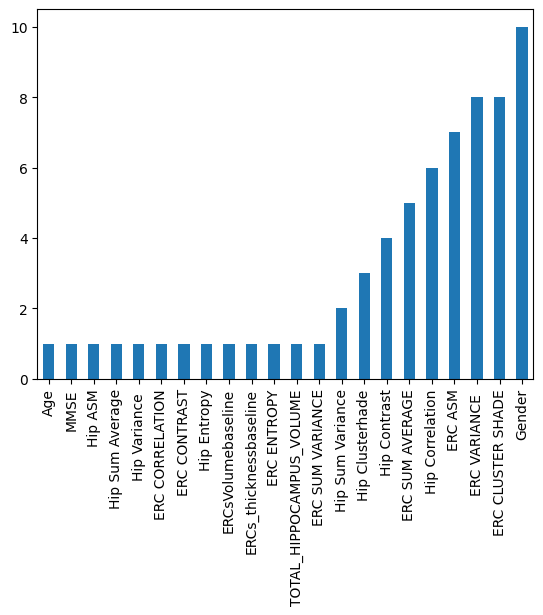

In [17]:
ranking = sel.ranking_
plot_ranking = pd.Series(ranking)
plot_ranking.index = X_train.columns
plot_ranking.sort_values().plot(kind="bar")

In [18]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((889, 13), (381, 13))

## Classification Test

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)
        
        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False)
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )
                
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "ANOVA",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [20]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_knn_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_knn_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_knn_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_knn_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train)

In [21]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Metric            Fit Time Total Features               
ANOVA             Random Forest       balanced_accuracy 2.441    22                   0.804   
                                                        1.041    13                   0.802   
                  XGBoost             balanced_accuracy 1.187    22                   1.000   
                                                        1.394    13                   1.000   
                  NGBoost             balanced_accuracy 4.609    22                   0.734   
                                                        2.512    13                   0.731   
                  Logistic Regression balanced_accuracy 0.061    22                   0.719   
                                                        0.029    13                   0.719   

                                                                                 Std Train  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 2.441    22                  0.006   
                                                        1.041    13                  0.008   
                  XGBoost             balanced_accuracy 1.187    22                  0.000   
                                                        1.394    13                  0.000   
                  NGBoost             balanced_accuracy 4.609    22                  0.010   
                                                        2.512    13                  0.009   
                  Logistic Regression balanced_accuracy 0.061    22                  0.006   
                                                        0.029    13                  0.006   

                                                                                 Mean Test  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 2.441    22                  0.686   
                                                        1.041    13                  0.703   
                  XGBoost             balanced_accuracy 1.187    22                  0.670   
                                                        1.394    13                  0.668   
                  NGBoost             balanced_accuracy 4.609    22                  0.653   
                                                        2.512    13                  0.655   
                  Logistic Regression balanced_accuracy 0.061    22                  0.678   
                                                        0.029    13                  0.685   

                                                                                 Std Test  
Feature Selection Classifier          Metric            Fit Time Total Features            
ANOVA             Random Forest       balanced_accuracy 2.441    22                 0.036  
                                                        1.041    13                 0.026  
                  XGBoost             balanced_accuracy 1.187    22                 0.044  
                                                        1.394    13                 0.047  
                  NGBoost             balanced_accuracy 4.609    22                 0.058  
                                                        2.512    13                 0.062  
                  Logistic Regression balanced_accuracy 0.061    22                 0.034  
                                                        0.029    13                 0.025

In [22]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)
        
        if classifier_name == "Logistic Regression":  
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)

        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [24]:
results = "filtered"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                             
Boruta            Random Forest       0.586               13             accuracy                   0.794   
                                                                         balanced_accuracy          0.784   
                                                                         precision                  0.810   
                                                                         recall                     0.794   
                                                                         f1_weighted                0.799   
                                                                         roc_auc_ovr_weighted       0.947   
                  XGBoost             0.203               13             accuracy                   1.000   
                                                                         balanced_accuracy          1.000   
                                                                         precision                  1.000   
                                                                         recall                     1.000   
                                                                         f1_weighted                1.000   
                                                                         roc_auc_ovr_weighted       1.000   
                  NGBoost             0.762               13             accuracy                   0.804   
                                                                         balanced_accuracy          0.730   
                                                                         precision                  0.799   
                                                                         recall                     0.804   
                                                                         f1_weighted                0.792   
                                                                         roc_auc_ovr_weighted       0.941   
                  Logistic Regression 0.094               13             accuracy                   0.741   
                                                                         balanced_accuracy          0.717   
                                                                         precision                  0.759   
                                                                         recall                     0.741   
                                                                         f1_weighted                0.748   
                                                                         roc_auc_ovr_weighted       0.892   

                                                                                               Test data  
Feature Selection Classifier          Classification Time Total Features Metric                           
Boruta            Random Forest       0.586               13             accuracy                  0.761  
                                                                         balanced_accuracy         0.735  
                                                                         precision                 0.781  
                                                                         recall                    0.761  
                                                                         f1_weighted               0.767  
                                                                         roc_auc_ovr_weighted      0.894  
                  XGBoost             0.203               13             accuracy                  0.787  
                                                                         balanced_accuracy         0.705  
                                                                         precision                 0.786  
                                                                         recall    